In [95]:
# import os
# os.environ["JAX_PLATFORM_NAME"] = "cpu"

import jax_sbgeom as jsb
%load_ext autoreload
%autoreload 2
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
import numpy as onp
import sys 
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)


from functools import partial
import jax_sbgeom.coils as jsc
import jax_sbgeom.flux_surfaces as jsf

from dataclasses import dataclass
import functools
from jax_sbgeom.jax_utils.utils import _mesh_to_pyvista_mesh
import pyvista as pv

vmec_files = ["/home/tbogaarts/stellarator_paper/base_data/vmecs/helias3_vmec.nc4", "/home/tbogaarts/stellarator_paper/base_data/vmecs/helias5_vmec.nc4", "/home/tbogaarts/stellarator_paper/base_data/vmecs/squid_vmec.nc4"]
vmec_file = vmec_files[2]

coil_files = ["/home/tbogaarts/stellarator_paper/base_data/vmecs/HELIAS3_coils_all.h5", "/home/tbogaarts/stellarator_paper/base_data/vmecs/HELIAS5_coils_all.h5", "/home/tbogaarts/stellarator_paper/base_data/vmecs/squid_coilset.h5"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [206]:

coilsd = onp.loadtxt("filament_s4uu_5ci_23")[:,:]
amax = 101
i = 0
coils = []
currents = []
for i in range(40):
#    if i not in [0, 4, 8, 12, 16, 20,24, 28, 32,35, 36,39] :
    coils.append(coilsd[i * amax : i * amax + amax -1,:-1])
    currents.append(coilsd[i * amax, -1])

print(coils[0])

jax_coils = [jsc.DiscreteCoil.from_positions(jnp.array(coil)) for coil in coils]

jax_currents = jnp.array(currents)

[[24.20931     1.349426   -0.2283899 ]
 [24.2587      1.204042    0.06605977]
 [24.30497     1.057268    0.3627309 ]
 [24.34262     0.9088968   0.6599188 ]
 [24.36467     0.7584607   0.9565476 ]
 [24.36347     0.6054828   1.252226  ]
 [24.33132     0.4495847   1.547475  ]
 [24.26185     0.2910478   1.843166  ]
 [24.15116     0.1312597   2.140002  ]
 [23.99842    -0.0270862   2.438231  ]
 [23.8062     -0.1799726   2.737446  ]
 [23.58028    -0.3222494   3.036511  ]
 [23.32906    -0.4480373   3.333643  ]
 [23.06268    -0.5513019   3.626586  ]
 [22.7919     -0.6263893   3.912424  ]
 [22.52693    -0.6687552   4.187886  ]
 [22.27611    -0.6757911   4.450085  ]
 [22.04494    -0.6473407   4.696702  ]
 [21.83553    -0.5859726   4.926037  ]
 [21.64632    -0.496968    5.136903  ]
 [21.47242    -0.3880072   5.328393  ]
 [21.30615    -0.2685777   5.499556  ]
 [21.13819    -0.1493728   5.649334  ]
 [20.95899    -0.04164923  5.77668   ]
 [20.75959     0.04420939  5.879658  ]
 [20.53271     0.09968781

In [207]:
coilset_2 = sbg.Coils.Discrete_Coil_Set_From_HDF5(coil_files[2])

fourier_coilset = sbg.Coils.Convert_to_Fourier_Coils(coilset_2, equal_arclength=True)


In [208]:
jax_coilset = jsc.CoilSet.from_list(jax_coils)

In [209]:
import StellBlanket.SBGeom as sbg

coilset_fourier_sbg = sbg.Coils.Convert_to_Fourier_Coils(sbg.Coil_Set([sbg.Discrete_Coil(onp.array(jax_coils[0].positions))]))


In [210]:
set_0 = coilset_fourier_sbg[0].Get_Fourier_Cos()

In [211]:
coilset = jsc.fourier_coil.convert_to_fourier_coilset(jax_coilset)

In [212]:
finitesize_coils = jsc.FiniteSizeCoilSet.from_coilset(coilset, jsc.RotationMinimizedFrame, 300)

In [213]:
def arc_length_fourier(fourier_coil, s):
    tangent = jsc.fourier_coil._grad_fourier_position(fourier_coil, s)
    return jnp.linalg.norm(tangent,axis=-1)


def arc_length_fd(fourier_coil, s):
    ds = 1e-6
    pos_plus = jsc.fourier_coil._fourier_position(fourier_coil, s + ds)
    pos_minus = jsc.fourier_coil._fourier_position(fourier_coil, s - ds)
    tangent = (pos_plus - pos_minus) / (2 * ds)
    return jnp.linalg.norm(tangent, axis=-1)

arclength = arc_length_fourier(coilset[0], jnp.linspace(0,1,1000, endpoint=False))

In [214]:
def arc_length_fd_discrete(discrete_coil, s):
    positions = discrete_coil.position( s)
    rolled_positions = jnp.roll(positions, -1, axis=0)
    diffs = rolled_positions - positions
    segment_lengths = jnp.linalg.norm(diffs, axis=-1) / (1 / len(s))
    return segment_lengths

arclength_fd_discrete_vals = arc_length_fd_discrete(jax_coilset[0], jnp.linspace(0,1,1000, endpoint=False))

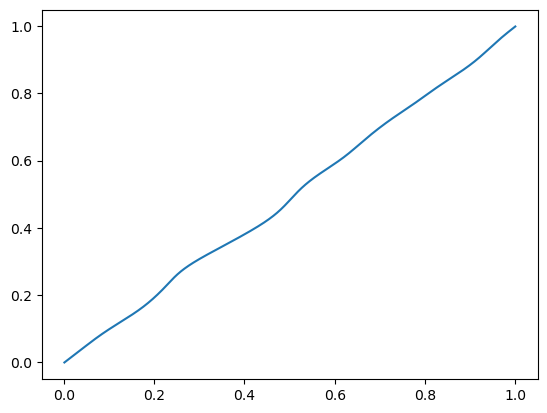

In [ ]:
def equal_arc_length_fourier(fourier_coil, n_s):
    s = jnp.linspace(0, 1, n_s, endpoint=False)
    arc_lengths = arc_length_fourier(fourier_coil,s)
    total_length = jnp.cumsum(arc_lengths) / n_s

    total_length_samples = total_length/ total_length[-1]
    
    s_new = jsb.jax_utils.utils.interpolate_array_mfodulo(total_length_samples, s)

    return s_new
    

snew = equal_arc_length_fourier(coilset[0], 1000)

plt.plot(snew, jnp.linspace(0,1,1000, endpoint=False))

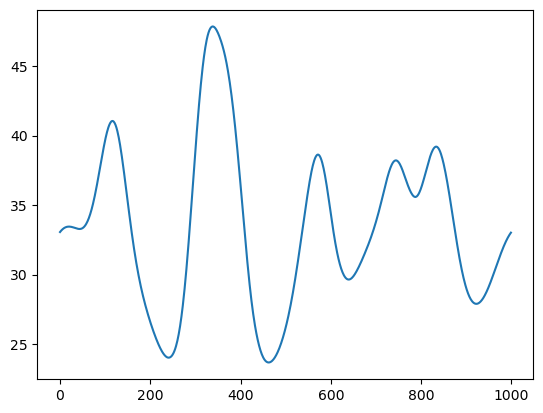

In [247]:
plt.plot(arc_length_fourier(coilset[0],snew), label="fourier")

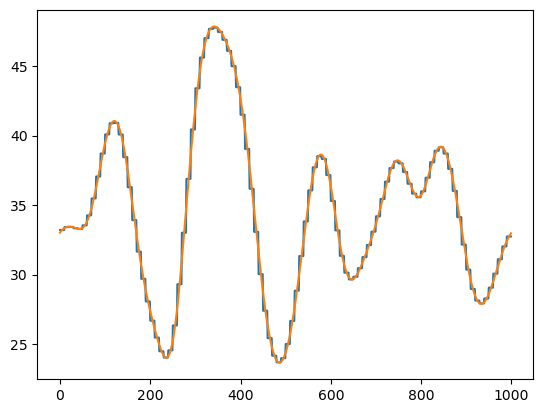

In [215]:
plt.plot(arclength_fd_discrete_vals)
plt.plot(arclength)

In [219]:
jsc.mesh_coilset_surface(finitesize_coils, 300, 0.3, 0.3)

(Array([[23.92124275,  1.60647668, -0.05248593],
        [23.90442923,  1.06768277, -0.3159597 ],
        [24.49737725,  1.09237532, -0.40429387],
        ...,
        [14.04264612, 20.53056378,  0.2958382 ],
        [14.18511539, 21.11328321,  0.28398157],
        [14.60649677, 21.0018696 , -0.128359  ]], dtype=float64),
 Array([[    0,     1,     4],
        [    1,     5,     4],
        [    1,     2,     5],
        ...,
        [47999, 46803, 46802],
        [47999, 47996, 46803],
        [47996, 46800, 46803]], dtype=int64))

In [221]:
onp.testing.assert_allclose(fourier_coilset[0].Get_Fourier_Sin(), coilset.coils.fourier_sin[0,...])

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

(shapes (99, 3), (50, 3) mismatch)
 ACTUAL: array([[ 1.233213e-01, -2.070988e+00,  5.055013e+00],
       [ 3.865446e-01,  3.060308e-01,  5.382646e-01],
       [-2.900628e-01, -6.234369e-01, -5.998721e-01],...
 DESIRED: array([[ 1.002810e-01, -2.045148e+00,  4.992878e+00],
       [ 2.531173e-01,  3.064740e-01,  5.580023e-01],
       [-2.970842e-01, -5.988043e-01, -7.627712e-01],...

In [222]:
fourier_coilset.Mesh_Triangles_RMF(0.3,0.3,300).vertices

array([[23.91856917,  1.60469088, -0.05429335],
       [23.90652147,  1.06642252, -0.31909897],
       [24.50005083,  1.09416112, -0.40248645],
       ...,
       [14.05020494, 20.4931436 ,  0.270848  ],
       [14.2659878 , 21.04542449,  0.36262803],
       [14.62394501, 20.98495437, -0.11508528]], shape=(48000, 3))

In [223]:
plotter = pv.Plotter(shape = (1,2))
plotter.subplot(0,0)
plotter.add_mesh(_mesh_to_pyvista_mesh(*jsc.mesh_coilset_surface(finitesize_coils, 300, 0.3, 0.3)), show_edges=True)
plotter.subplot(0,1)
plotter.add_mesh(fourier_coilset.Mesh_Triangles_RMF(0.3,0.3,300).to_pyvista(), opacity=1.0, show_edges=True)
plotter.link_views()
plotter.show()


Widget(value='<iframe src="http://localhost:46405/index.html?ui=P_0x7e2d3334cbc0_24&reconnect=auto" class="pyv…